In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
%cd /content/
!pip install wget
!git clone https://github.com/KKMOfficial/minGPT.git
!pip3 install torch torchvision torchaudio
import wget
!mkdir /content/VQVAE
valid_link = "https://drive.usercontent.google.com/download?id=1vY9l-110dFmbqm2AkRNllqp0MnXJaxH6&export=download&authuser=0&confirm=t&uuid=018afe8b-f360-451b-bac4-f8e714956771&at=APZUnTWO3XNqjvhgXvPBJ6GMkbxT%3A1723832924892"
wget.download(valid_link, out="/content/VQVAE/valid_trajs.pkl")

train_link = "https://drive.usercontent.google.com/download?id=1tY_DBuZT7XhysO0I11ASW64knTcDVm1P&export=download&authuser=0&confirm=t&uuid=61dc4bed-3d20-4494-9036-f24d24cb66cd&at=APZUnTUIyzkTvbx8uyyv7xllzNDH%3A1724174332424"
wget.download(train_link, out="/content/VQVAE/train_trajs.pkl")

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import pickle, numpy as np
from quantizer import get_quantizer


class VQVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=9, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=7, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
        )

        self.en_skip_conv = nn.Conv1d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=183, stride=1, padding=0)

        # Vector Quantization
        self.quantizer = get_quantizer(num_embeddings, embedding_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=embedding_dim, out_channels=hidden_dim, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(in_channels=hidden_dim, out_channels=input_dim, kernel_size=7, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(in_channels=input_dim, out_channels=input_dim, kernel_size=16, stride=2, padding=1),
        )

        self.dc_skip_conv = nn.ConvTranspose1d(in_channels=embedding_dim, out_channels=input_dim, kernel_size=183, stride=1, padding=0)

    def encode(self, x):
        z_e = self.en_skip_conv(x) + self.encoder(x)
        z_e = z_e.permute(0, 2, 1)  # Change shape for quantization
        return z_e

    def decode(self, z_q):
        return self.dc_skip_conv(z_q) + self.decoder(z_q)

    def forward(self, x):
        z_e = self.encode(x)
        z_q, q_loss ,indices = self.quantizer(z_e)
        x_recon = self.decode(z_q.permute((0,2,1)))
        return x_recon, q_loss, indices

def train_vqvae(model, train_data_loader, validation_data_loader, num_epochs, learning_rate, device, check_point_path, model_path, commitment_cost=0.25):
    best_validation_loss = -1
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_history = []

    try:
      for epoch in range(num_epochs):
          model.train()
          total_loss = 0

          for bidex,batch in enumerate(train_data_loader):
              batch = batch.to(device)
              optimizer.zero_grad()
              x_recon, quantize_loss, indices = model(batch)
              recon_loss      = F.mse_loss(x_recon, batch)
              loss = recon_loss + quantize_loss
              loss.backward()
              optimizer.step()
              total_loss += recon_loss.item()
              print(f'Batch Index [{bidex + 1}/{num_epochs}], Partial Loss: {recon_loss.item():.4f}')

              train_history += [recon_loss.item()]

          avg_loss = total_loss / len(train_data_loader)
          print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

          model.eval()
          total_val_loss = 0
          with torch.no_grad():
              for batch in validation_data_loader:
                  batch = batch.to(device)
                  x_recon, quantize_loss, indices = model(batch)
                  recon_loss      = F.mse_loss(x_recon, batch)
                  loss = recon_loss + quantize_loss
                  total_val_loss += recon_loss.item()
              avg_val_loss = total_val_loss / len(validation_data_loader)
              print(f'Validation Loss: {avg_val_loss:.4f}')

              if avg_val_loss < best_validation_loss:
                  print(f'saving model...')
                  torch.save(model.state_dict(), model_path)
                  best_validation_loss = avg_val_loss
              else:
                  print(f'saving check-point...')
                  torch.save(model.state_dict(), check_point_path)
              # log information
              # train_history.append([avg_loss, avg_val_loss])
    except:
        print(f'saving model...')
        torch.save(model.state_dict(), model_path)
        return train_history
    return train_history

In [9]:
class StatesDataset(Dataset):
    """
    generates states!
    """
    def __init__(self, traj_address, min_range=-100, max_range=400, precision=1e-2):

        self.data    = []
        with open(traj_address,"rb") as f: self.traj_list = pickle.load(f)
        for trajectory in self.traj_list :
            self.data += [datum for index,datum in enumerate(trajectory) if index%2==0]
        self.data = np.array(self.data)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

In [10]:
# configure path
# root_directory       = "E:/MoCAP/MCDH/minGPT/"
# drive_directory      = "E:/MoCAP/MCDH/minGPT/"
root_directory = "/content/VQVAE/"
drive_directory= "/content/drive/MyDrive/VQVAE/"
check_point_path     = f"{drive_directory}vqvae_check_point.pt"
model_path           = f"{drive_directory}vqvae_best_model.pt"
train_dataset_path   = f'{root_directory}train_trajs.pkl'
valid_dataset_path   = f'{root_directory}valid_trajs.pkl'
history_file_path    = f'{drive_directory}history_t_v.pkl'
train_batch_size     = 100
valid_batch_size     = 100
load_model           = False

# Hyperparameters
input_dim = 1
hidden_dim = 44
num_embeddings = 1024
embedding_dim = 44
num_epochs = 3
learning_rate = 1e-3

train_dataset = StatesDataset(train_dataset_path)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=0,
)

valid_dataset = StatesDataset(valid_dataset_path)
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=valid_batch_size,
    shuffle=True,
    num_workers=0,
)

# Initialize the model
model = VQVAE(input_dim, hidden_dim, num_embeddings, embedding_dim)

if load_model:
    print(f"loading model...")
    model.load_state_dict(torch.load(model_path))
else:
    print(f"train from scratch...")

# Train the model
train_history = train_vqvae(model, train_loader, valid_loader, num_epochs, learning_rate, torch.device('cuda'), check_point_path, model_path)

with open(history_file_path,"wb") as f:
    pickle.dump(train_history, f)

Streaming output truncated to the last 5000 lines.
Batch Index [1719/3], Partial Loss: 0.0562
Batch Index [1720/3], Partial Loss: 0.0536
Batch Index [1721/3], Partial Loss: 0.0517
Batch Index [1722/3], Partial Loss: 0.0468
Batch Index [1723/3], Partial Loss: 0.0522
Batch Index [1724/3], Partial Loss: 0.0576
Batch Index [1725/3], Partial Loss: 0.0546
Batch Index [1726/3], Partial Loss: 0.0518
Batch Index [1727/3], Partial Loss: 0.0525
Batch Index [1728/3], Partial Loss: 0.0470
Batch Index [1729/3], Partial Loss: 0.0514
Batch Index [1730/3], Partial Loss: 0.0569
Batch Index [1731/3], Partial Loss: 0.0555
Batch Index [1732/3], Partial Loss: 0.0499
Batch Index [1733/3], Partial Loss: 0.0471
Batch Index [1734/3], Partial Loss: 0.0581
Batch Index [1735/3], Partial Loss: 0.0526
Batch Index [1736/3], Partial Loss: 0.0564
Batch Index [1737/3], Partial Loss: 0.0515
Batch Index [1738/3], Partial Loss: 0.0504
Batch Index [1739/3], Partial Loss: 0.0477
Batch Index [1740/3], Partial Loss: 0.0500
Bat

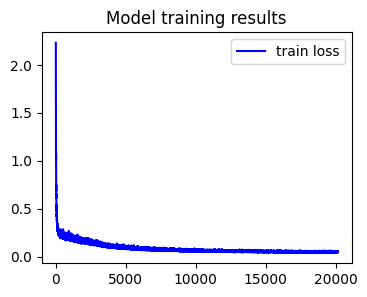

In [12]:
import numpy as np, pickle
import matplotlib.pyplot as plt

time_steps = range(len(train_history))
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(time_steps, train_history, color='#0000FF', label='train loss')
ax.legend()
ax.set_title('Model training results')
plt.show()